#Análise de parâmetros SkipGram e CBOW

### Em resumo esse trabalho inclui três partes fundamentais

* *Preparação de um corpus (pré-processamento)*

* *Aprendizado um modelo de linguagem word2vec (SkipGram e CBOW)*

* *Avaliação de parâmetros desses modelos (utilizando como medida de avaliação a distância euclidiana para analogias)*


Pedro Henrique Silva Rodrigues

2020681662

### Obtenção do corpus (utilizado para treinar os modelos)
### Obtenção de analogias utilizadas na avaliação

In [ ]:
#Baixando algumas analogias
!git clone https://github.com/nicholas-leonard/word2vec

Cloning into 'word2vec'...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (139/139), 117.30 KiB | 612.00 KiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
#Baixando o corpus
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip

--2021-02-15 00:51:12--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   729KB/s    in 43s     

2021-02-15 00:51:55 (707 KB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


### Pré-processamento dos dados
#### Uma das partes mais importantes em modelos de linguagem e o pré-processamento. O pré-processamento aplicado nesse trabalho é o *default* da biblioteca **Gensim** (essa biblioteca também será utilizada para treinar os modelos de linguaguem). O pré-processamento do **Gensim** inclui as seguintes etapas 

* Essa etapa tem por objetivo remover palavras digitadas de forma (que podem inserir ruído nos dados)
* Reduzir uma palavra ao seu **radical** (pode ajudar os modelos de linguagem a melhorar na capacidade de generalização)
* Remoção de **stop-words** (palavras frequentemente utilizadas para estruturar frases mas que no geral tem pouco significado)
* Para a representação semântica que será calculada pelo CBOW e SkipGmam passar todas as palavras para minúsculo pode ajudar a melhorar esses modelos.
* Números e pontuação também podem são removidos


In [ ]:
with open('word2vec/questions-words.txt', 'r') as qw_file:
    lines_qw = qw_file.readlines()

with open('text8', 'r') as corpus_file:
    corpus = corpus_file.readlines()[0]

print(f"Nº caracteres no corpus (sem pré-processamento): {len(corpus)}")


Nº caracteres no corpus (sem pré-processamento): 100000000


In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, stem_text, \
    strip_short, remove_stopwords, strip_multiple_whitespaces

filtered_corpus = corpus.lower()
filtered_corpus = strip_punctuation(filtered_corpus)
filtered_corpus = strip_multiple_whitespaces(filtered_corpus)
filtered_corpus = strip_numeric(filtered_corpus)
filtered_corpus = remove_stopwords(filtered_corpus)
filtered_corpus = strip_short(filtered_corpus)
filtered_corpus = stem_text(filtered_corpus)

print(f"Nº caracteres no corpus (com pré-processamento): {len(filtered_corpus)}")

Nº caracteres no corpus (com pré-processamento): 57413933


### Análise do impacto do pré-processamento na qualidade do modelo

#### Primeiramente verificamos o impacto do pré-processamento na qualidade do modelo (para fixar qual estratégia será utilizada nas próximas análises)

Com o pré-processamento remove-se uma quantidade grande de caracteres (há uma redução de 40% no tamanho do corpus original)

In [ ]:
corpus[0:100]

' anarchism originated as a term of abuse first used against early working class radicals including t'

In [ ]:
filtered_corpus[0:100]

'anarch origin term abus earli work class radic includ digger english revolut san culott french revol'

In [ ]:
print(f"Redução Nº caracteres pelo pré-processamento: {100 - len(filtered_corpus)/len(corpus)*100}%")

Redução Nº caracteres pelo pré-processamento: 42.58606700000001%


In [ ]:
type(filtered_corpus)

str

* Aqui define-se duas funções que serão utilizadas pelo restante do notebook: *train_model_cbow* e *train_model_skipGram*, essas funções tomam como entradas parâmetros dos respectivos modelos e retornam uma instância da classe do **Gensim** treinada no corpus passado como parâmetro 

In [ ]:
from gensim.models import Word2Vec

def train_model_cbow(corpus_to_train, min_count, size, window):
    model = Word2Vec(corpus_to_train, min_count=min_count, size=size, window=window, workers=2)
    return model

def train_model_skipGram(corpus_to_train, min_count, size, window):
    model = Word2Vec(corpus_to_train, min_count=min_count, size=size, window=window, workers=2, sg=1)
    return model

* Aqui defini-se a função de avaliação que será utiliza pelo resto do notebook. Ela toma como entrada um modelo (já treinado do **Gensim**), as analogias carregadas do arquivo baixado no começo, e retorna um vetor com as distância euclidianas para cada uma das analogias se o modelo conhece essas palavras.
* Cada analogia é composta de 4 palavras, a representação das duas primeiras são somadas e subtraída da terceira.
* Computa-se a distância do vetor formado pela operação acima, do vetor que representa a quarta palavra no modelo.

In [ ]:
from scipy.spatial.distance import euclidean
import numpy as np

def evaluate_model_distance(trained_model, analogies, stemmed=None):
    word_vectors = trained_model.wv
    all_distances = []
    def run_sttem(some_word):
        if stemmed is None:
            return some_word
        return stemmed(some_word)

    for line in analogies:
        if ": " in line: continue
        spllitted_line = line.strip().replace("\n", "").split(' ')
        stemmed_spllitted_line = []
        for word in spllitted_line:
            stemmed_spllitted_line.append(run_sttem(word))
        # checa se todas as palavras da analogia estão no modelo treinado
        flag = True
        for word_spl in stemmed_spllitted_line:
            if not word_spl in word_vectors.vocab:
                flag = False
        if flag:
            positive = trained_model[stemmed_spllitted_line[0]]
            positive = np.array(positive) + np.array(trained_model[stemmed_spllitted_line[1]])
            result = positive - np.array(trained_model[stemmed_spllitted_line[2]])

            distance_to_correct_analogie = euclidean(result, trained_model[stemmed_spllitted_line[3]])
            all_distances.append(distance_to_correct_analogie)
    return all_distances

* Treinamento e avaliação do CBOW e SkipGram com o corpus puro e o corpus pré-processado

** As análises a partir desse ponto utilizam os parâmetros *default* do **Gensim**. Ao encontrar parâmetros que impactam com grande discrepância a qualidade do modelo essas são substituídos nas análises seguintes para o que teve melhor resultado 

In [ ]:
cbow_trained_on_filtered_corpus = train_model_cbow([filtered_corpus.split(" ")], min_count=5, size=100, window=5)
skipgram_trained_on_filtered_corpus = train_model_skipGram([filtered_corpus.split(" ")], min_count=5, size=100, window=5)

cbow_trained_on_corpus = train_model_cbow([corpus.split(" ")], min_count=5, size=100, window=5)
skipgram_trained_on_corpus = train_model_skipGram([corpus.split(" ")], min_count=5, size=100, window=5)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
resultado_cbow_filtered = evaluate_model_distance(cbow_trained_on_filtered_corpus, lines_qw, stem_text)
resultado_skipgram_filtered = evaluate_model_distance(skipgram_trained_on_filtered_corpus, lines_qw, stem_text)
resultado_cbow = evaluate_model_distance(cbow_trained_on_corpus, lines_qw, None)
resultado_skipgram = evaluate_model_distance(skipgram_trained_on_corpus, lines_qw, None)
print(np.mean(resultado_cbow))
print(np.mean(resultado_skipgram))
print(np.mean(resultado_cbow_filtered))
print(np.mean(resultado_skipgram_filtered))

0.06566942834988572
0.3925666570707467
0.02006477331226754
0.05456250466586837


* Para avaliar se o uso da filtragem tem diferença estatística com o uso do corpus normal, computou-se o t-test para avaliar a diferença entre os dois vetores com as distâncias para as analogias
** Há uma confiança alta de que os resultados são diferentes. Tanto para SkipGram quanto para CBOW o uso do corpus pré-processado é melhor    

In [ ]:
from scipy import stats
_, p_value = stats.ttest_ind(resultado_cbow, resultado_cbow_filtered)
print("p-value: " + str(p_value))
_, p_value = stats.ttest_ind(resultado_skipgram, resultado_skipgram_filtered)
print("p-value: " + str(p_value))

p-value: 1.2753936537278124e-15
p-value: 0.0


* Gráficos de Comparação do impacto do pré-processamento na qualidade do modelo

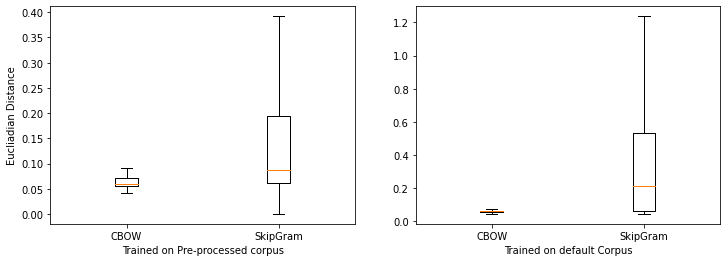

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].boxplot([resultado_cbow_filtered, resultado_skipgram_filtered], showfliers=False)
ax[0].set_xticklabels(['CBOW', 'SkipGram'])
ax[0].set_ylabel("Eucliadian Distance")
ax[0].set_xlabel("Trained on Pre-processed corpus")
ax[1].boxplot([resultado_cbow, resultado_skipgram], showfliers=False)
ax[1].set_xticklabels(['CBOW', 'SkipGram'])
ax[1].set_xlabel("Trained on default Corpus")
plt.show()

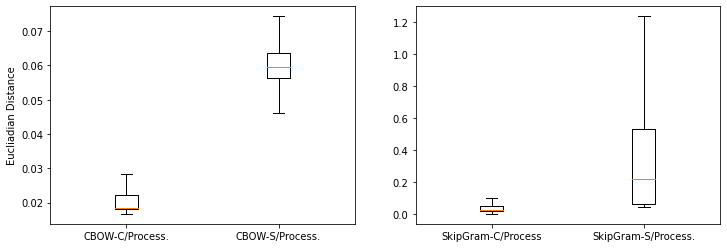

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].boxplot([resultado_cbow_filtered, resultado_cbow], showfliers=False)
ax[0].set_xticklabels(['CBOW-C/Process.', 'CBOW-S/Process.'])
ax[0].set_ylabel("Eucliadian Distance")
# ax[0].set_xlabel("Trained on Pre-processed corpus")
ax[1].boxplot([resultado_skipgram_filtered, resultado_skipgram], showfliers=False)
ax[1].set_xticklabels(['SkipGram-C/Process', 'SkipGram-S/Process.'])
# ax[1].set_xlabel("Trained on default Corpus")
plt.show()

### Análise do impacto do tamanho do contexto na qualidade dos modelos

* As análises a partir desse ponto utilizam apenas o corpus filtrado



In [ ]:
resultados_window_cbow = []
resultados_window_skipgram = []
windows = [2, 5, 10, 20]
for window in windows:
    cbow_trained_on_filtered_corpus = train_model_cbow([filtered_corpus.split(" ")], min_count=5, size=100, window=window)
    skipgram_trained_on_filtered_corpus = train_model_skipGram([filtered_corpus.split(" ")], min_count=5, size=100, window=window)

    resultado_cbow_filtered = evaluate_model_distance(cbow_trained_on_filtered_corpus, lines_qw, stem_text)
    resultado_skipgram_filtered = evaluate_model_distance(skipgram_trained_on_filtered_corpus, lines_qw, stem_text)

    resultados_window_cbow.append(resultado_cbow_filtered)
    resultados_window_skipgram.append(resultado_skipgram_filtered)

* Para ambos os métodos, utilizar contextos muito grandes diminui na qualidade e aumenta a variância das distâncias para as analogias

* Isso está relacionado ao fato de que contextos muito grandes são pouco informativos, uma vez que começam a misturar contextos não relacionados.

* Valores pequenos (2 e 5) foram os melhores valores encontrados para o parâmetro *window*. Contextos pequenos sofrem menos com o problema de mistura de contextos. 

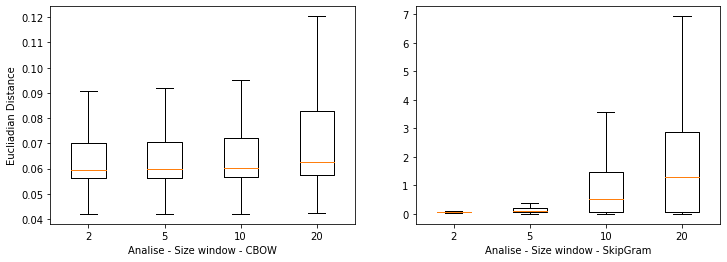

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].boxplot(resultados_window_cbow, showfliers=False)
ax[0].set_xticklabels(['2', '5', '10', '20'])
ax[0].set_ylabel("Eucliadian Distance")
ax[0].set_xlabel("Analise - Size window - CBOW")
ax[1].boxplot(resultados_window_skipgram, showfliers=False)
ax[1].set_xticklabels(['2', '5', '10', '20'])
ax[1].set_xlabel("Analise - Size window - SkipGram")
plt.show()

### Análise do impacto da remoção de palavras não frequentes

* Palavras que não ocorrem com frequência podem estar relacionadas a erros de digitação (incluindo ruído no modelo)
* Pode-se utilizar o parâmetro *min_count* para filtrar do aprendizado as palavras que aparecem com frequência menor que a estipulada no parâmetro
* Apesar de ser uma boa estratégia podem estar sendo removidas palavras raras mas imporntantes em seus contextos
* As próximas células avaliam a qualidade do modelo quando esse parâmetro é alterado 

In [ ]:
resultados_min_count_cbow = []
resultados_min_count_skipgram = []
min_counts = [2, 5, 10, 20, 100]
for min_count in min_counts:
    cbow_trained_on_filtered_corpus = train_model_cbow([filtered_corpus.split(" ")], min_count=min_count, size=100, window=5)
    skipgram_trained_on_filtered_corpus = train_model_skipGram([filtered_corpus.split(" ")], min_count=min_count, size=100, window=5)

    resultado_cbow_filtered = evaluate_model_distance(cbow_trained_on_filtered_corpus, lines_qw, stem_text)
    resultado_skipgram_filtered = evaluate_model_distance(skipgram_trained_on_filtered_corpus, lines_qw, stem_text)

    resultados_min_count_cbow.append(resultado_cbow_filtered)
    resultados_min_count_skipgram.append(resultado_skipgram_filtered)

* Para ambos os métodos, aumentar o valor de *min_count* diminui a qualidade do modelo e aumenta a variância das distâncias.

* Isso está relacionado ao fato de que valores grandes estão removendo palavras importantes da coleção. 

* Escolhemos valores muito grandes (20 e 100) e muito pequenos (2, 5) para variar pois a quantidade de *typos* está muito relacionada a origem dos dados (e não temos a informação da origem dos dados)

* Valores pequenos (2 e 5) foram os melhores valores encontrados para o parâmetro *min_count*

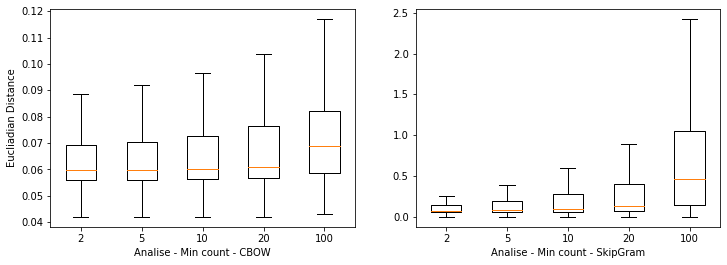

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].boxplot(resultados_min_count_cbow, showfliers=False)
ax[0].set_xticklabels(['2', '5', '10', '20', '100'])
ax[0].set_ylabel("Eucliadian Distance")
ax[0].set_xlabel("Analise - Min count - CBOW")
ax[1].boxplot(resultados_min_count_skipgram, showfliers=False)
ax[1].set_xticklabels(['2', '5', '10', '20', '100'])
ax[1].set_xlabel("Analise - Min count - SkipGram")
plt.show()

### Análise do impacto do tamanho da representação calculada para as palavras

* O tamanho da representação está relacionado a quantidade de fatores latentes aprendidos pelo modelo
** Valores muito grandes podem ocasionar **overfitting** do modelo, pois os fatores podem começam a capturar contextos muito específicos
* Valores muito pequenos carregam pouca informação (dependendo do tamanho do corpus)
* É um parâmetro importante de ser testado e avaliado em cada aplicação individualmente

In [ ]:
resultados_size_cbow = []
resultados_size_skipgram = []
sizes = [10, 100, 1000]
for size in sizes:
    cbow_trained_on_filtered_corpus = train_model_cbow([filtered_corpus.split(" ")], min_count=2, size=size, window=5)
    skipgram_trained_on_filtered_corpus = train_model_skipGram([filtered_corpus.split(" ")], min_count=2, size=size, window=5)

    resultado_cbow_filtered = evaluate_model_distance(cbow_trained_on_filtered_corpus, lines_qw, stem_text)
    resultado_skipgram_filtered = evaluate_model_distance(skipgram_trained_on_filtered_corpus, lines_qw, stem_text)

    resultados_size_cbow.append(resultado_cbow_filtered)
    resultados_size_skipgram.append(resultado_skipgram_filtered)

* Como esperado valores muito pequenos tem valores de distância muito variados e altos, e conforme aumenta-se o tamanho do *embedding* obtem-se valores menores e mais variados
** Salienta-se que uma análise de overfitting seria necessária para determinar o melhor valor para esse parâmetro, porém como temos poucos dados essa análise não levaria a boas conclusões

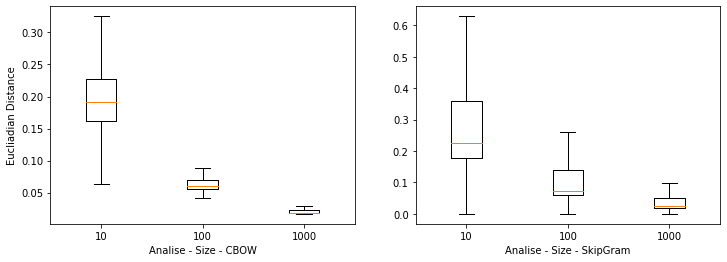

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].boxplot(resultados_size_cbow, showfliers=False)
ax[0].set_xticklabels(['10', '100', '1000'])
ax[0].set_ylabel("Eucliadian Distance")
ax[0].set_xlabel("Analise - Size - CBOW")
ax[1].boxplot(resultados_size_skipgram, showfliers=False)
ax[1].set_xticklabels(['10', '100', '1000'])
ax[1].set_xlabel("Analise - Size - SkipGram")
plt.show()

### Análise do impacto do tamanho do corpus na qualidade do modelo

* Para mostrar como o impacto do corpus afeta a qualidade de um modelo de linguagem, montou-se o script abaixo que treina e avalia o SkipGram e o CBOW no corpus com diferentes tamanhos

In [ ]:
resultados_size_cbow = []
resultados_size_skipgram = []
percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for percent in percents:
    corpus_resized = [filtered_corpus.split(" ")[0:int((percent/100)*len(filtered_corpus))]]
    cbow_trained_on_filtered_corpus = train_model_cbow(corpus_resized, min_count=2, size=10, window=5)
    skipgram_trained_on_filtered_corpus = train_model_skipGram(corpus_resized, min_count=2, size=10, window=5)

    resultado_cbow_filtered = evaluate_model_distance(cbow_trained_on_filtered_corpus, lines_qw, stem_text)
    resultado_skipgram_filtered = evaluate_model_distance(skipgram_trained_on_filtered_corpus, lines_qw, stem_text)

    resultados_size_cbow.append(np.mean(resultado_cbow_filtered))
    resultados_size_skipgram.append(np.mean(resultado_skipgram_filtered))

* Os resultados são difíceis de analisar, pois ao reduzir o corpus também reduz-se a quantidade de analogias que seu vocabulário contém

* Como é mostrado nos valores abaixo a qualidade não varia conforme diminui-se o tamanho da coleção

A quantidade de analogias que esses dados possuem é relativamente pequena

In [ ]:
resultados_size_cbow

[0.19857971318598908,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695,
 0.19710969714069695]

In [ ]:
resultados_size_skipgram

[0.3442835685669513,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097,
 0.324688078324097]

* Os resultados da análise do impacto do tamanho são pouco conclusivos

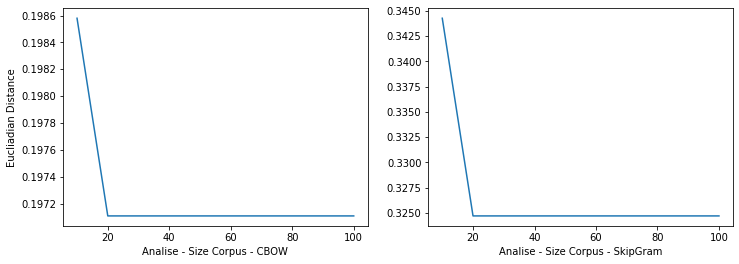

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(percents, resultados_size_cbow, '-')
ax[0].set_ylabel("Eucliadian Distance")
ax[0].set_xlabel("Analise - Size Corpus - CBOW")
ax[1].plot(percents, resultados_size_skipgram, '-')
ax[1].set_xlabel("Analise - Size Corpus - SkipGram")
plt.show()

### Análise de sanidade nos modelos

* Treinou-se CBOW e Skip-Gram com os melhores parâmetros obtidos ao longo das análises desse notebook 

* Foram feitos alguns testes com base nas analogias e sumarizamos aqui alguns resultados obtidos

In [ ]:
cbow_trained_on_filtered_corpus = train_model_cbow([filtered_corpus.split(" ")], min_count=5, size=100, window=5)
skipgram_trained_on_filtered_corpus = train_model_skipGram([filtered_corpus.split(" ")], min_count=5, size=100, window=5)

cbow_trained_on_corpus = train_model_cbow([corpus.split(" ")], min_count=5, size=100, window=5)
skipgram_trained_on_corpus = train_model_skipGram([corpus.split(" ")], min_count=5, size=100, window=5)

resultado_cbow_filtered = evaluate_model_distance(cbow_trained_on_filtered_corpus, lines_qw, stem_text)
resultado_skipgram_filtered = evaluate_model_distance(skipgram_trained_on_filtered_corpus, lines_qw, stem_text)
resultado_cbow = evaluate_model_distance(cbow_trained_on_corpus, lines_qw, None)
resultado_skipgram = evaluate_model_distance(skipgram_trained_on_corpus, lines_qw, None)
print(np.mean(resultado_cbow))
print(np.mean(resultado_skipgram))
print(np.mean(resultado_cbow_filtered))
print(np.mean(resultado_skipgram_filtered))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


0.06669422991245696
0.3935464641461439
0.06333455626341918
0.18741541650913215


* Os modelos CBOW calculam boas representações até mesmo para nomes próprios como Mandela
** A representação de Mandela está bem próximo a liberdade e vida 

In [ ]:
similar_words = cbow_trained_on_corpus.wv.most_similar('libert', topn=5)	
for s in similar_words:
    print(s)	

('lugdunum', 0.40361326932907104)
('mandela', 0.37973928451538086)
('guy', 0.3786759674549103)
('ladd', 0.3760763704776764)
('transcendence', 0.373094767332077)


In [ ]:
similar_words = cbow_trained_on_corpus.wv.most_similar('mandela', topn=5)	
for s in similar_words:
    print(s)	

('lifes', 0.4236471354961395)
('bech', 0.3882291615009308)
('libert', 0.37973928451538086)
('pcw', 0.3769081234931946)
('construct', 0.3686670660972595)


* Os modelos CBOW e Skip-Gram também são bem consistentes quanto a proximidade de palavras frequentes como liberdade
** Ambos retornam palavras em comum nas palavras mais similares a liberdade

In [ ]:
similar_words = skipgram_trained_on_corpus.wv.most_similar('libert', topn=5)	
for s in similar_words:
    print(s)	

('lugdunum', 0.40361326932907104)
('mandela', 0.37973928451538086)
('guy', 0.3786759674549103)
('ladd', 0.3760763704776764)
('transcendence', 0.373094767332077)


In [ ]:
similar_words = cbow_trained_on_filtered_corpus.wv.most_similar('libert', topn=5)	
for s in similar_words:
    print(s)	

('informatiqu', 0.4364084005355835)
('adject', 0.4346124529838562)
('lugdunum', 0.40361326932907104)
('goven', 0.3817792236804962)
('mandela', 0.37973928451538086)


* Apesar de semelhantes esses modelos podem aprender representações bem diferentes.
** A similaridade de Canadá e US é bem diferente nos modelos

In [ ]:
similarity_two_words = cbow_trained_on_filtered_corpus.wv.similarity('canada','us')
print("CBOW - Similarity between 'canada' and 'us':")
print(similarity_two_words)

CBOW - Similarity between 'canada' and 'us':
0.17558593


In [ ]:
similarity_two_words = skipgram_trained_on_filtered_corpus.wv.similarity('canada','us')
print("Skipgram - Similarity between 'canada' and 'us':")
print(similarity_two_words)

Skipgram - Similarity between 'canada' and 'us':
0.87475365


* Apesar de distâncias relativamente pequenas em média, esses modelos não necessariamente "acertam" todas as analogias. A variância vista nos gráficos apresentados previamente são uma forte evidência de tal, assim como a analogia abaixo 

In [ ]:
skipgram_trained_on_filtered_corpus.most_similar(positive=['berlin', 'german'], negative=['franc'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('neurotoxin', 0.4150747060775757),
 ('beadwork', 0.377780020236969),
 ('swazi', 0.3724031448364258),
 ('autobahn', 0.3718569278717041),
 ('antiochu', 0.36370518803596497),
 ('iommi', 0.3604356348514557),
 ('effortlessli', 0.35576915740966797),
 ('motl', 0.3547203838825226),
 ('costanza', 0.34625959396362305),
 ('bloat', 0.3396640419960022)]

* Ambos os modelos também não performam bem quando as analogias estão relacionadas a países e capitais

In [ ]:
similarity_two_words = cbow_trained_on_filtered_corpus.wv.similarity('berlin','german')
print(similarity_two_words)

0.013144135


In [ ]:
similarity_two_words = skipgram_trained_on_filtered_corpus.wv.similarity('berlin','german')
print(similarity_two_words)

0.122898005


In [ ]:
# Berlin Germany Paris France
similarity_two_words = cbow_trained_on_filtered_corpus.wv.similarity('paris','franc')
print(similarity_two_words)

-0.08094745


In [ ]:
# Berlin Germany Paris France
similarity_two_words = skipgram_trained_on_filtered_corpus.wv.similarity('paris','franc')
print(similarity_two_words)

-0.05189859


* Outro exemplo de como esses modelos podem aprender representações diferentes

In [ ]:
similar_words = cbow_trained_on_filtered_corpus.wv.most_similar('govern', topn=5)
for s in similar_words:
    print(s)		

('gazpacho', 0.40031176805496216)
('rosco', 0.3888137936592102)
('barroso', 0.381699800491333)
('aquarii', 0.3723788857460022)
('cooee', 0.35817021131515503)


In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('govern', topn=5)
for s in similar_words:
    print(s)		

('anarchist', 0.9965792298316956)
('state', 0.9964113831520081)
('us', 0.9962377548217773)
('form', 0.9960969090461731)
('includ', 0.995941698551178)


* Foi feito um "passeio" a partir do radical "construct" no SkipGram para verificar a localidade dessa palavra
** A partir de "construct" mostramos as 5 palavras mais próximas a esssa, obtem-se a primeira e mostra-se as 5 palavras mais próximas a esssa. Esse procedimento se repete algumas vezes

** Saindo de "construct" , que tem similaridade a "greek" "effect" "like" e "present" chegou-se a "autism", "autist", "person" e "disord"

** Essa relação pode de fator existir, tanto como pode ser uma sobreposição de fatores latentes. A explicabilidade dos *embeddings* aprendidos está ainda longe de compreensão

In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('construct', topn=5)
for s in similar_words:
    print(s)		

('syndrom', 0.9621579647064209)
('greek', 0.9619190096855164)
('effect', 0.9619088172912598)
('like', 0.96177077293396)
('present', 0.9614266157150269)


In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('syndrom', topn=5)
for s in similar_words:
    print(s)		

('disord', 0.9991387128829956)
('autism', 0.9990975856781006)
('spectrum', 0.9990131855010986)
('development', 0.9988155364990234)
('person', 0.9986175894737244)


In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('disord', topn=5)
for s in similar_words:
    print(s)		

('autism', 0.9995739459991455)
('spectrum', 0.9993277788162231)
('development', 0.9991860389709473)
('autist', 0.9991596937179565)
('syndrom', 0.9991387128829956)


In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('autism', topn=5)
for s in similar_words:
    print(s)		

('autist', 0.999607264995575)
('disord', 0.9995738863945007)
('spectrum', 0.9994676113128662)
('person', 0.9993842840194702)
('peopl', 0.9993510246276855)


In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('person', topn=5)
for s in similar_words:
    print(s)		

('autism', 0.9993844628334045)
('autist', 0.999144434928894)
('peopl', 0.9990424513816833)
('disord', 0.9989722967147827)
('children', 0.9989047050476074)


In [ ]:
similar_words = skipgram_trained_on_filtered_corpus.wv.most_similar('citizen', topn=5)
for s in similar_words:
    print(s)		

('ewa', 0.39683759212493896)
('hydrofoil', 0.37788885831832886)
('aunu', 0.36188048124313354)
('boardgamegeek', 0.3610531985759735)
('megalomania', 0.3581652045249939)


* *doesnt_match* é um método que retorna a palavra que não deveria estar presente na lista - Os métodos acertam em alguns casos porém não acertam sempre 

In [ ]:
skipgram_trained_on_filtered_corpus.wv.doesnt_match(['us', 'children', 'person'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'us'

In [ ]:
skipgram_trained_on_filtered_corpus.wv.doesnt_match(['brazil', 'canada', 'person'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'brazil'

* Fez-se ainda uma análise semelhante a do site abaixo em que as representações são reduzidas com PCA e TSNE e pode-se comparar a posição relativa de palavras relacionadas e outras palavras (apenas para realizar uma checagm espacial)



In [ ]:
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

    

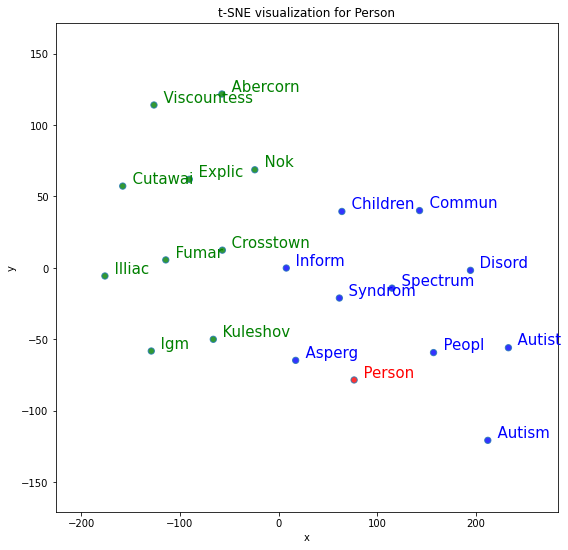

In [ ]:
words = []
for i in range(10):
    index = np.random.randint(0, len(skipgram_trained_on_filtered_corpus.wv.index2word) - 1)
    words.append(skipgram_trained_on_filtered_corpus.wv.index2word[index])

tsnescatterplot(skipgram_trained_on_filtered_corpus, 'person', words)

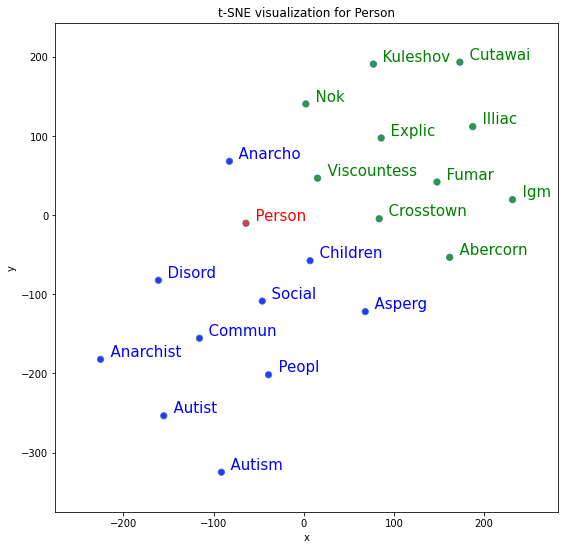

In [ ]:
# words = []
# for i in range(10):
#     index = np.random.randint(0, len(skipgram_trained_on_filtered_corpus.wv.index2word) - 1)
#     words.append(skipgram_trained_on_filtered_corpus.wv.index2word[index])

tsnescatterplot(cbow_trained_on_filtered_corpus, 'person', words)

* Com essas análise foi possível estimar e entender a importância dos parâmetros dos modelos de linguagem CBOW e SkipGram